## Chapter 2: Derivatives and Automatic Differentiation

# 2.4  Automatic Differentiation - the forward mode

In the previous Section we detailed how we can derive derivative formulae for any function constructed from elementary functions and operations, and how derivatives of such functions are themselves constructed from elementary functions/operations.  These facts have far-reaching consequences for the practical computing of derivatives - allowing us to construct a very effective derivative calculator called *Automatic Differentiation* which we detail here.

More specifically we describe how one can quickly code up the so-called *forward mode* of Automatic Differentiation, a natural and direct implementation of the method for calculating derivatives 'by hand' using a computation graph as discussed in the previous Section.  Leveraging closed form derivative rules - instead of e.g., numerical approximation - the Automatic Differentiator it is typically more accurate than the Numerical Differentiation calculator discussed in the second Section of this series, and has no parameters that require tuning.

While the AD calculator employs the derivative rules in precisely the same manner we have seen previously, it will *not* produce an algebraic description of a derivative but its programmatic analog: a program-based function / subroutine.  Remember as we saw in the previous Section, in computing derivatives we always construct a function evaluation $g(w)$ and its derivative $\frac{\mathrm{d}}{\mathrm{d}w}g(w)$ simultaneously - and this will be fundamental aspect of our implementation here.

In [3]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import numpy as np
import matplotlib.pyplot as plt
from mlrefined_libraries import calculus_library as calclib
from mlrefined_libraries import basics_library as baslib

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

## 2.4.1  The basic building block of an AD calculator: the input variable $w$

Since the input $w$ represents the simplest function we could possibly wish to differentiate (i.e., $g(w) = w$), and since every other mathematical function is built by combining elementary functions / operations involving $w$, a logical first step in building an AD calculator is to simply implement a numerical version of $w$.  Because we need to keep track of both the evaluation and its derivative value this implementation needs to be a *tuple* - a set of two values - both the evaluation of $w$ at a given input and its derivative.  Now obviously since we always have that $\frac{\mathrm{d}}{\mathrm{d}w}w = 1$ the derivative value never changes, but we need to keep track of it nonetheless (since we will build in other derivative rules on top of $w$).

Below we define a simple class called ``MyTuple`` that implements the input variable $w$ (note: for those wanting a good introduction to Python classes in the context of mathematical functions see e.g., [this excellent book](http://hplgit.github.io/primer.html/doc/pub/class/class-readable.html).).  Instances of this class are a tuple containing ``val`` - the value of $w$ which is pre-set to ``val = 0`` but will be adjusted to any user-defined value - and ``der`` - the derivative of $w$ which is  initialized at ``der = 1``.

In [5]:
class MyTuple:
    '''
    The basic object representing the input variable 'w'
    represents the core of our AD calculator.  An instance 
    of this class is a tuple containining one function/derivative
    evaluation of the variable 'w'.  Because it is meant to 
    represent the simple variable 'w' the derivative 'der' is
    preset to 1.  The value 'val' can be set to 0 by default.  
    '''
    def __init__(self,**kwargs):
        # variables for the value (val) and derivative (der) of our input function 
        self.val = 0
        self.der = 1    
        
        # re-assign these default values 
        if 'val' in kwargs:
            self.val = kwargs['val']
        if 'der' in kwargs:
            self.der = kwargs['der']

## 2.4.2  Creating derivative rules for elementary functions

With our base constructed we can quickly code up the derivative rules for elementary functions contained in Table 1 of the previous Section, which we repeat here for convenience.

<br>
  <center>
  <caption>Table 1: Derivative formulae for elementary functions</caption>
  </center> 
<table>
  <col width="160">
  <col width="100">
  <col width="100">
<thead>
<tr>
    <th>elementary function</th>
    <th>equation</th> 
    <th>derivative</th>
  </tr>
  </thead>
  <tbody>
    <tr>
    <td>constant</td>
    <td>$c$</td>
    <td>$0$</td>
  </tr>
  <tr>
    <td>monomial (degree $p\neq 0$)</td>
    <td>$w^p$</td>
    <td>$pw^{p-1}$</td>

  </tr>
    <tr>
    <td>sine</td>
    <td>$\text{sin}(w)$</td>
    <td>$\text{cos}(w)$</td>
  </tr>
  <tr>
    <td>cosine</td>
    <td>$\text{cos}(w)$</td>
    <td>$-\text{sin}(w)$</td>
  </tr>
  <tr>
    <td>exponential</td>
    <td>$e^w$</td>
    <td>$e^w$</td>
  </tr>
  <tr>
    <td>logarithm</td>
    <td>$\text{log}(w)$</td>
    <td>$\frac{1}{w}$</td>
  </tr>
    <tr>
    <td>hyperbloic tangent</td>
    <td>$\text{tanh}(w)$</td>
    <td>$1 - \text{tanh}^2(w)$</td>
  </tr>
      <tr>
    <td>rectified linear unit (ReLU) </td>
    <td>$\text{max}\left(0,w\right)$</td>
    <td>$\begin{cases}0 & w\leq0\\1 & w>0\end{cases}$</td>
  </tr>
  </tbody>
</table>

Since our variable $w$ (our ``MyTuple`` object) keeps track of both the function and derivative values, all we need to do in order to create one of these rules as a ``Python`` function is define how the elementary rule transforms the function and derivative evaluation. 

#### <span style="color:#a50e3e;">Example 1. </span> Programming the derivative of $g(w) = \text{sin}(w)$ and $g(w) = \text{cos}(w)$

For example, we have a Python function for the sinusoid update rule in the next cell.  Notice this is almost a direct translation of the corresponding rule to code: we first record how the function itself (``sin``) should affect the ``val`` attribute of an input, and then how its derivative should affect the corresponding ``der`` attribute.

In [4]:
# our implementation of the sinusoid rule from Table 1
def sin(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = np.sin(a.val)

    # Produce new derivative value - we need to use the chain rule here!
    b.der = np.cos(a.val)*a.der
    
    # Return updated object
    return b

Here we input $a$, an ```MyTuple``` object with a current function and derivative value, and create a new instance to contain their updates called $b$.  To get the new function update

```
b.val = np.sin(a.val)
```

we simply pass the current value through a sinusoid.  The corresponding derivative value update 

```
b.der = np.cos(a.val)*a.der
```

involves two parts.  The sinusoid derivative rule alone would have us update the derivative value by simply passing ```a.val``` through cosine.  But remember - as discussed in the previous Section - that every time we apply an elementary derivative formula we must apply the *chain rule* as well.  This is why we multiply ```np.cos(a.val)``` by ```a.der``` in the update.

We can now test our sinusoid function over a few input points, as is done in the next cell.  

In [4]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: sin(w)

# initialize our AutoDiff object at each point
a1 = MyTuple(val = 0); a2 = MyTuple(val = 0.5)

# evaluate
result1 = g(a1); result2 = g(a2)

# print results
print ('function value at ' + str(0) + ' = ' + str(result1.val))
print ('derivaive value at ' + str(0) + ' = ' + str(result1.der))

print ('function value at ' + str(0.5) + ' = ' + str(result2.val))
print ('derivaive value at ' + str(0.5) + ' = ' + str(result2.der))

function value at 0 = 0.0
derivaive value at 0 = 1.0
function value at 0.5 = 0.479425538604
derivaive value at 0.5 = 0.87758256189


This looks fine - so lets evaluate over a large range of inputs and visualize both the function and derivative values.  In the next Python cell we use a short custom plotting function that performs the above evaluations over a large range of input values, and then plots the resulting function/derivative values.

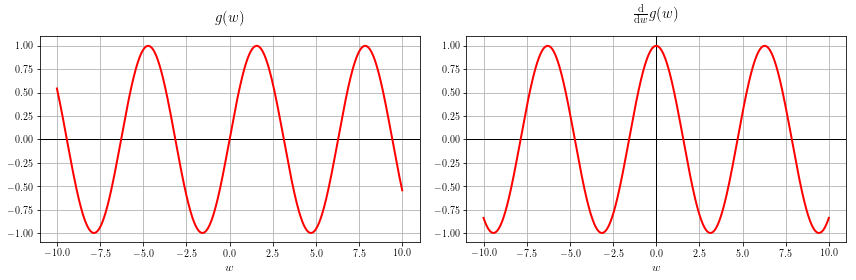

In [5]:
# define a function using our AD components
g = lambda w: sin(w)

# use custom plotter to evaluate function/derivative over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g)

And indeed this is correct: the function evaluation is sine and the derivative evaluation is cosine over the entire input range.

We can just as easily define a cosine function as well, and do so in the next Python cell.

In [6]:
# our implementation of the cosine rule from Table 1
def cos(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = np.cos(a.val)

    # Produce new derivative value - we need to use the chain rule here!
    b.der = -np.sin(a.val)*a.der
    
    # Return updated object
    return b

#### <span style="color:#a50e3e;">Example 2. </span> Programming the derivative of $g(w) = w^n$

We can define a power rule precisely as done with the sinusoid function in the previous example: updating the current function evaluation using the elementary function, and the current derivative value using the corresponding derivative rule from Table 1.  Once again we must include an instance of the chain rule with our derivative update.

In [7]:
# our implementation of the power rule from Table 1 
def power(a,n):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = a.val**n

    # Produce new derivative value - we need to use the chain rule here!
    b.der = n*(a.val**(n-1))*a.der
    
    # Return updated object
    return b

And we can test out this function by evaluating/plotting over a large range of inputs, say the third degree monomial $w^2$.

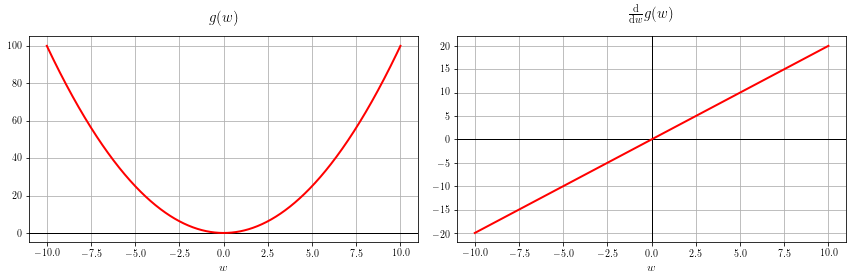

In [8]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: power(w,2)

# use the custom plotting function above to plot function/derivative over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g)

Again everything looks good.

#### <span style="color:#a50e3e;">Example 3. </span> Programming the derivative of $g(w) = \text{tanh}(w)$

As with the previous examples we can define the $\text{tanh}$ function, making sure to include the chain rule with our update of the derivative value.

In [9]:
# our implementation of the power rule from Table 1 
def tanh(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = np.tanh(a.val)

    # Produce new derivative value
    b.der = (1 - np.tanh(a.val)**2)*a.der
    
    # Return updated object
    return b

And we can test our new tanh function over a range of values.

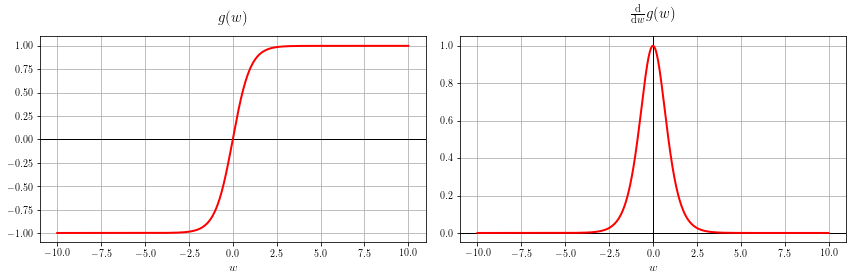

In [10]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: tanh(w)

# use the custom plotting function above to plot function/derivative over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g)

This is correct!  We can of course verify that this is correct by plotting the function and derivative equations given in the table.  We do this in the next cell using a custom plotting function.

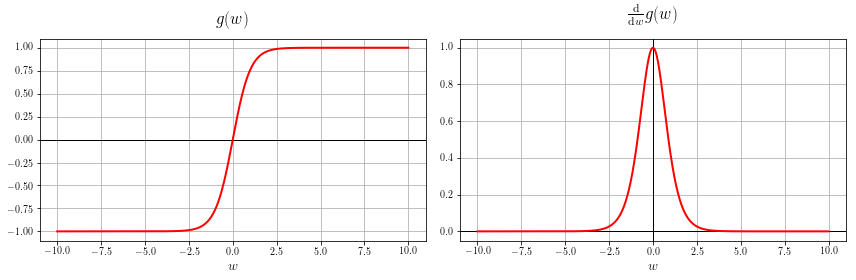

In [11]:
# define function and its derivative equations using numpy
g = lambda w: np.tanh(w)
dgdw = lambda w: (1 - np.tanh(w)**2)

# plot both
calclib.plotter.derval_eq_plot(g,dgdw)

#### <span style="color:#a50e3e;">Example 4. </span> Programming the derivative of $g(w) = \text{log}(w)$

Mirroring the previous examples we can code up the derivative rule for log as follows.

In [12]:

# our implementation of the sinusoid rule from Table 1
def log(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = np.log(a.val)

    # Produce new derivative value
    b.der = (1/a.val)*a.der
    
    # Return updated object
    return b

And quickly testing it out, we see that it indeed works.

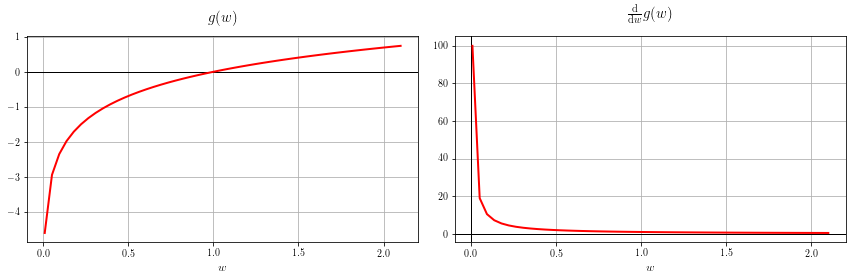

In [13]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: log(w)
w = np.linspace(0.01,2.1000)

# use the custom plotting function above to plot over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g,w=w)

---

We can very easily continue, defining a function for each elementary derivative rule precisely as we have done here with these three examples.  The only wrinkle to remember with each is that we must include an instance of the chain rule with each derivative update from Table 1. 

## 2.4.3 Creating derivative rules for elementary operations

In the previous Section we described derivative rules for each elementary operation, which we repeat below for convenience. 

<br>
<center>
  <caption>Table 2: Derivative formulae for elementary operations</caption>
</center>
<table>
  <col width="820">
  <col width="180">
  <col width="650">
<thead>
<tr>
    <th>operation</th> 
    <th>equation</th>
    <th>derivative rule</th>    
  </tr>
  </thead>
  <tbody>
     <tr>
    <td> addition of a constant $c$ </td>
    <td> $g(w) + c$</td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}\left(g(w) + c\right)=  \frac{\mathrm{d}}{\mathrm{d}w}g(w)$</td>
  </tr> 
    <tr>
    <td> multiplication by a constant $c$ </td>
    <td> $cg(w)$</td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}\left(cg(w)\right)=  c\frac{\mathrm{d}}{\mathrm{d}w}g(w)$</td>
  </tr>  
  <tr>
  <td> addition of functions (often called the summation rule)</td>
    <td> $f(w) + g(w)$ </td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}(f(w) + g(w))=  \frac{\mathrm{d}}{\mathrm{d}w}f(w) + \frac{\mathrm{d}}{\mathrm{d}w}g(w)$</td>
  </tr> 
  <tr>
  <td> multiplication of functions (often called the product rule) </td>
    <td> $f(w)g(w)$ </td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}(f(w)\cdot g(w))=  \left(\frac{\mathrm{d}}{\mathrm{d}w}f(w)\right)\cdot g(w) + f(w)\cdot \left(\frac{\mathrm{d}}{\mathrm{d}w}g(w)\right)$
    </td>
  </tr>
  <tr>
  <td> composition of functions (often called the chain rule)</td>
    <td> $f(g(w))$ </td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}(f(g(w)))= \frac{\mathrm{d}}{\mathrm{d}g}f(g) \cdot \frac{\mathrm{d}}{\mathrm{d}w}g(w)$
  </td>
  </tr>
  <tr>
  <td> maximum of two functions </td>
    <td> $\text{max}(f(w),\,g(w))$ </td>
    <td>$\frac{\mathrm{d}}{\mathrm{d}w}(\text{max}(f(w),\,g(w))) = \begin{cases}\frac{\mathrm{d}}{\mathrm{d}w}f\left(w\right) & \text{if}\,\,\,f\left(w\right)\geq g\left(w\right)\\\frac{\mathrm{d}}{\mathrm{d}w}g\left(w\right) & \text{otherwise}\end{cases}$</td>
  </tr> 
  </tbody>
</table>

As with the derivative formulae for elementary functions, implementing these rules means providing - in each case - an update for the function and derivative value.  We walk through several examples below.

#### <span style="color:#a50e3e;">Example 5. </span> Programming up the addition rules

In addition to making sure we update function and derivative values, when coding up the addition rules we may as well knock out both of the addition rules in Table 2: defining the derivative of a function and constant, and two functions.  A simple switch or if/else statement is used below to sort between these two cases.

In [14]:
# our implementation of the addition rules from Table 2
def add(a,b):
    # Create output evaluation and derivative object
    c = MyTuple()
    
    # switch to determine if a or b is a constant
    if type(a) != MyTuple:
        c.val = a + b.val
        c.der = b.der
    elif type(b) != MyTuple:
        c.val = a.val + b
        c.der = a.der
    else: # both inputs are MyTuple objects, i.e., functions
        c.val = a.val + b.val
        c.der = a.der + b.der
    
    # Return updated object
    return c

With the addition rules taken care of above we can try it out using two of the elementary function rules coded in the previous subsection.  In particular we test with the sum 

$$
\text{sin}(w) + w
$$

since both the sinusoid and the power function update rules were coded previously.

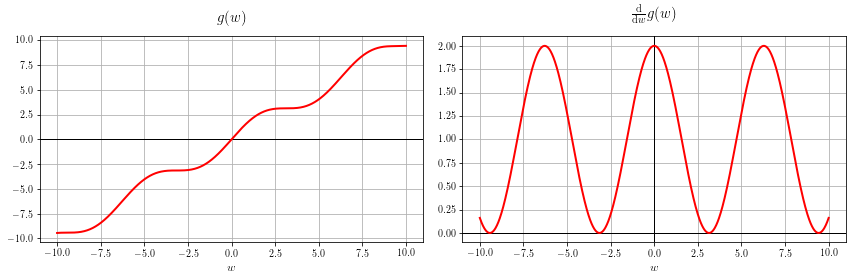

In [15]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: add(sin(w),w)

# use the custom plotting function above to plot over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g)

Notice here that the computation graph for our input function - which includes derivative rules for both elementary functions and operations - is *implicitly* constructed and computed on when we pass a MyTuple object through the function ```add(sin(w),w)```.  In other words, while we do not have the computation graph itself we are traversing it to construct the function/derivative values just as we did by hand in the previous Section.

#### <span style="color:#a50e3e;">Example 6. </span> Coding up the multiplication rules

Since we also have several multiplication rules - what to do with the product of a constant and a function, and two functions - we can also  wrap both rules up into one Python function, using a switch or if/else to distinguish between them.

In [16]:
# our implementation of the addition rules from Table 2
def multiply(a,b):
    # Create output evaluation and derivative object
    c = MyTuple()

    # switch to determine if a or b is a constant
    if type(a) != MyTuple:
        c.val = a*b.val
        c.der = a*b.der
    elif type(b) != MyTuple:
        c.val = a.val*b
        c.der = a.der*b

    else: # both inputs are MyTuple objects i.e., functions
        c.val = a.val*b.val
        c.der = a.der*b.val + a.val*b.der     # product rule
    
    # Return updated object
    return c

With the multiplication rules taken care of above we can try it out using two of the elementary function rules coded in the previous subsection.  In particular we test with the sum 

$$
\text{sin}(w)\times w^2
$$

since both the sinusoid and the power function update rules were coded previously.

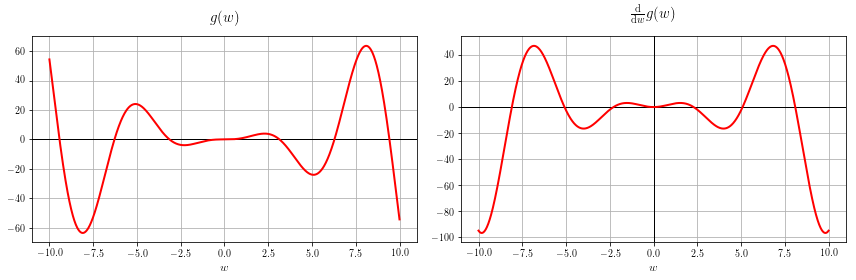

In [17]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: multiply(sin(w),power(w,2))

# use the custom plotting function above to plot over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g)

Notice here that the computation graph for our input function - which includes derivative rules for both elementary functions and operations - is implicitly constructed and computed on when we pass a MyTuple object through the function ```multiply(sin(w),power(w,2))```.

Its easy to check that this is correct by plotting the derivative equation itself, which using the elementary function/operation rules can be written as

$$
\frac{\mathrm{d}}{\mathrm{d}w}g(w) = 2\text{sin}(w)w + \text{cos}(w)w^2
$$

We plot this equation directly, along with the original function, in the next Python cell.

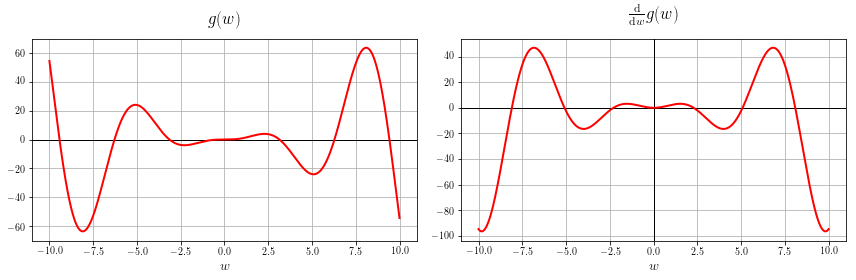

In [18]:
# define function and its derivative equations
g = lambda w: np.sin(w)*w**2
dgdw = lambda w: 2*np.sin(w)*w + np.cos(w)*w**2

# plot both
calclib.plotter.derval_eq_plot(g,dgdw)

## 2.4.4  Improving usability via operator overloading

With our current AD calculator setup we have just seen that in order to compute the derivative of 

$$
g(w) = \text{sin}(w) + w
$$

we use the somewhat clunky Python notation
                    
                        add(sin(w),w)

to invoke the summation derivative rule, and compute the derivative of the function.  In this subsection we briefly discuss how one can *overload operators* in Python to make the call above look more similar to the algebraic form of the function.

Python reserves symbols like ```+``` and ```*``` to denote a Python functions that perform standard addition and multiplication *on floating point objects*.  This means that if we try to use one of these symbols on our *MyTuple* object directly we will receive an error like 

    unsupported operand type(s) for +: 'MyTuple' and 'MyTuple'

because our objects differ from the intended input to Python's default addition function, the one assigned to the ```+``` operator.  We try this in the next Python cell, and indeed we provoke an error.

In [19]:
# create two MyTuple objects and try to use Python's built in function assigned to the + operator on them
a = MyTuple(); b = MyTuple();
a + b

TypeError: unsupported operand type(s) for +: 'MyTuple' and 'MyTuple'

We have already defined an addition function for MyTuple objects, one that updates both function and derivative values, and can force Python to use this function whenever we write use symbol ```+``` in the context of MyTuple objects.  This is called *operator overloading*, in short we re-define the function Python uses when it sees a particular operator like ```+```.  

Because we want the operator ```+``` to behave differently for MyTuple objects we must overload it in the class definition of MyTuple.  So, we can go back and add our ```add``` function in the MyTuple class definition.  In order to tell Python to use this function to overload the ```+``` operator we use the special function name ```__add__```, as shown in the abbreviated version of the ```add``` function below.

```
# our implementation of the addition rules from Table 2
def __add__(self,a,b):
    # Create output evaluation and derivative object
    c = MyTuple()
    .
    .
    .
    # Return updated object
    return c
```


We can also do this on the fly, appending our ```add``` function to the class definition, and we do this in the next Python cell.  

In [20]:
# this next line overloads the addition operator for our MyTuple objects, or in other words adds the 'add' function to our MyTuple class definition on the fly
MyTuple.__add__ = add

# overload the reverse direction so that a + b = b + a
MyTuple.__radd__ = add

Note we also overload the operator ```__radd__``` above as well, because in Python different functions can be assigned to ```+``` depending on the ordering of the two elements being operated on.  i.e., we can assign different functions to ```+``` for each scenario

                    __add__: assigns operation to a + b
                   __radd__: assigns operation to b + a
                    
if we so desired.  Of course we want Python to interpret ```+``` with our objects so that these two are equal

                    a + b = b + a
                    
Since we want to treat both the same way, and so overload ```__radd__``` with our ```add``` function as well.

Now we can use the ```+``` symbol with our MyTuple objects, and Python will employ our own ```add``` function to combine the two objects.  We demonstrate this in the next Python cell.

In [21]:
# create two MyTuple objects and try to use Python's built in function assigned to the + operator on them
a = MyTuple(); b = MyTuple();
a + b
b + a

We can do precisely the same thing with other natural Python operators reserved for multiplication ```*```, subtraction ```-```, raising to a power ```**```, etc.,  You can see a full list of operators that can be overwritten [here](http://www.python-course.eu/python3_magic_methods.php).  The more of these we overload appropriately the more user-friendly our AD calculator becomes.  

Since we have already made functions for multiplying and raising MyType objects to a power, we overload these two operators on the fly in the next Python cell.

In [22]:
# create two MyTuple objects and try to use Python's built in function assigned to the * operator on them
MyTuple.__mul__ = multiply

# overload the 'reverse multiplication' so that a*b = b*a
MyTuple.__rmul__ = multiply    

# create two MyTuple objects and try to use Python's built in function assigned to the ** operator on them
MyTuple.__pow__ = power

With these operators overloaded we can write out several of the previous examples more naturally, which we do in the next few Python cells.

#### <span style="color:#a50e3e;">Example 7. </span> Multiple more complicated examples written with overloaded operators

For example we calculated the derivative above as

$$
g(w) = \text{sin}(w)w^2
$$

which we first had to write as

                    multiply(sin(w),power(w,2))
                    
Now we can write this derivative calculation much more naturally as

                    sin(w)*w**2

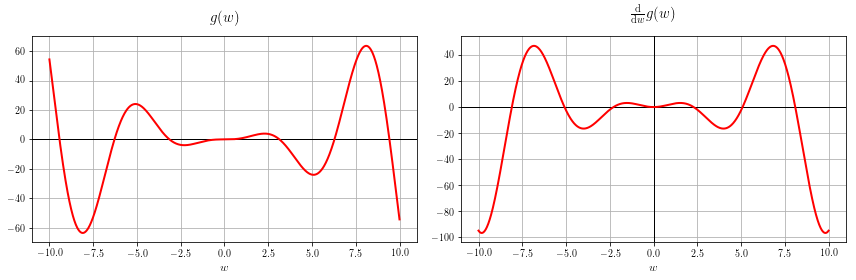

In [23]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: sin(w)*w**2

# use the custom plotting function above to plot over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g)

In the previous Section we also computed (by hand) and plotted the derivatives of the following by hand, and plotted the derivative function explicitly.

\begin{array}
\
g(w) =  \text{sin}(w^3) \\
g(w) = \text{tanh}(w)\text{cos}(w) + \text{log}(w) \\
g(w) =  \frac{\text{cos}(20w)}{w^2 + 1} \\
\end{array}

In the next three Python cells we use our AD calculator to compute these derivatives, and plot the results.

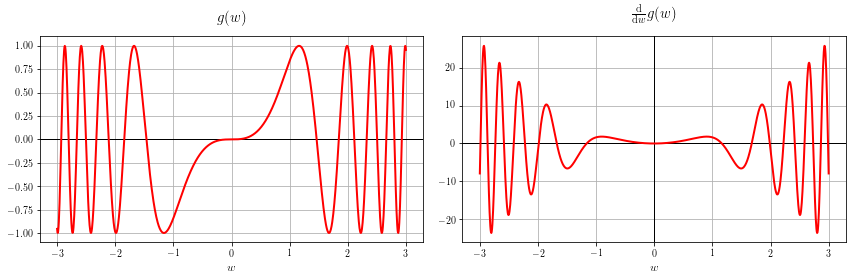

In [24]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: sin(w**3)
w = np.linspace(-3,3,1000)

# use the custom plotting function above to plot over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g,w=w)

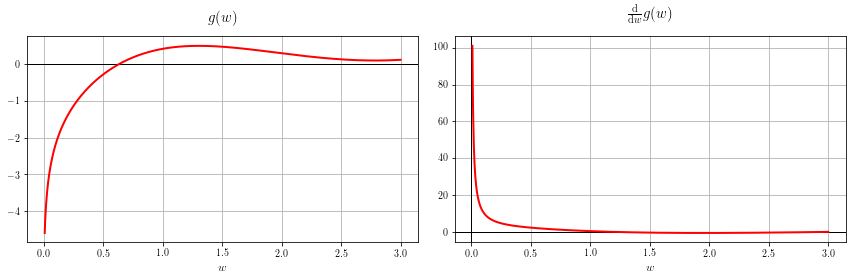

In [25]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: tanh(w)*cos(w) + log(w)
w = np.linspace(0.01,3,1000)

# use the custom plotting function above to plot over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g,w=w)

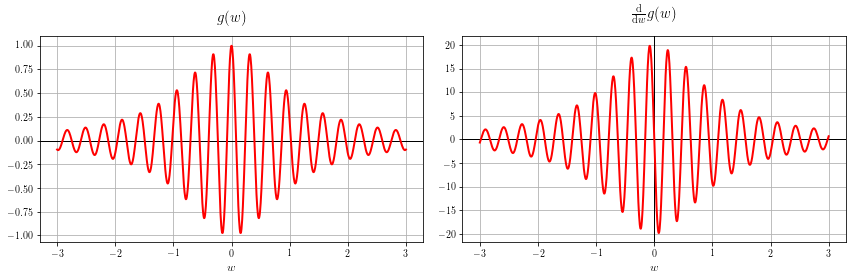

In [26]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: cos(20*w)*(w**2 + 1)**(-1)
w = np.linspace(-3,3,1000)

# use the custom plotting function above to plot over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g,w=w)

Correct again!

## 2.4.5 Variations in the construction of basic AD calculators

In constructing our AD calculator here we made a number of engineering choices which - in short - lead to a light weight piece of code that we can develop and use rather quickly, and that is (we hope) fairly easy to understand.  However there are other engineering choices one can make, some of which are merely stylistic while others present trade-offs in terms of usability and extendibility.  We review a few of the more crucial engineering choices below.

**Deciding on a direction for information flow - should we compute derivatives sweeping forward or backward through the computation graph?**

The computation graph is a powerful tool for recursively describing how a mathematical function is constructed, how it is evaluated, and how its derivative is formed.  In particular, in the previous Section we saw how *recursively sweeping forward or backward through a computation graph* breaks down large derivative calculations into a long sequence of much smaller more manageable ones.  When performing these calculations by hand our main concerns were in computing each step accurately, and keeping the many computations organized.  Thankfully because recursive algorithms are so naturally dealt with using for loops / while loops, the computation graph provides a bridge for thinking about how to perform / organize computations involving mathematical functions - like e.g., derivative calculations - on a computer instead of by hand.

But which way should we perform these computations - going forward or backward through the graph?  This is really up to us to decide, for the AD calculator we built here we computed derivatives going *forward*.  This is the simpler of the two choices in terms of book keeping and recursive computation, which is why it was primary method used in the examples of the previous Section.

**How do we represent the computation graph of a function?**

Because AD calculations are made using the computation graph of a function $g(w)$, one engineering choice to be made is to decide how the graph will be constructed and manipulated by our AD algorithm.  Essentially we have two choices: we can either construct the computation graph *implicitly* - as we did in the implementation we built here - or we can parse the input function $g(w)$ construct its computation graph *explicitly* as we did in pictures in the previous Section.  The advantage of implicitly constructing the graph is that the corresponding calculator is light weight and easy to construct.  On the other hand, implementing a calculator that explicitly constructs computation graphs requires additional technology (like e.g., a parser).  

While the choice to implicitly represent the computation graph makes the job of implementing an AD calculator easier, it does mean that we will need to make certain adjustments in order to extend the use of the calculator to e.g., higher order derivatives.  Since the sort of optimization algorithms used in machine learning / deep learning almost universally use only first and second order derivatives, this is not too damning.  However this is in contrast to explicitly constructing the computation graph, which allows for immediate higher order derivative calculations.  This is because such an AD calculator takes in a function to differentiate and treats it as a computation graph, and outputs the computation graph of its derivative (which can then be plugged back into the same calculator to differentiate).

**Should we compute the algebraic derivative, or the derivative evaluated at user-defined input values?**

The forward mode AD calculator we built here does not provide an algebraic description of a function's derivative, but a programmatic function that can be used to evaluate the function and its derivative at any set of input points.  Conversely one can build an algorithm that employs the basic derivative rules to provides an algebraic derivative, but this requires the implementation of a [computer algebra system](https://en.wikipedia.org/wiki/Computer_algebra_system).  Such a derivative calculator - that deals with derivatives using symbolic computation (i.e., algebra on the computer) - is called a *Symbolic Differentiator*.  However there are a few reasons why - at least for machine learning / deep learning applications - why *Automatic Differentiation* is a better choice.  

First of all for our applications we only need a calculator that can provide a programmatic-based description for the derivative - i.e., one that provides precise derivative value at selected input points - which the AD calculator provides.  

Secondly the AD calculator requires fewer tools to build, as it requires only basic coding methods and no computer algebra systems.

Finally, expressing derivative equations algebraically can be quite unwieldy.  For example, the rather complicated looking function

\begin{equation}
g(w) = \text{sin}\left(e^{\,5\text{tanh}^2(w) + w^5}\right)\text{log}\left(\frac{1}{w^2 + 1} \right)\frac{w^2 + 1}{\text{cos}(\text{sin}(w))}
\end{equation}

has an expansive algebraic derivative.   Below are just the first few terms 

\begin{equation}
\frac{\mathrm{d}}{\mathrm{d}w}g(w) = -2w\,\text{sin}\left(e^{\,5\text{tanh}^2(w) + w^5}\right) \, \frac{1}{\text{cos}(\text{sin}(w))} + 2w\,\text{log}\left(\frac{1}{w^2 + 1}\right)\text{sin}\left(e^{\,5\text{tanh}^2(w) + w^5}\right)\frac{1}{\text{cos}(\text{sin}(w))} + \cdots
\end{equation}

And this sort of problem is exponentially worse - to the point of being a considerable computational burden - when dealing with multivariable functions.  Such an example illustrates the real need to automatic *simplifying* of algebraic expressions as well, ideally during the differentiation process to make sure things do not get too far out of hand.  The AD calculator we built here - while not algebraic method - essentially does this simplifying automatically while computing derivatives. 

# 2.8 Automatic differentiation for multi-input functions 

Automatic differentiation, discussed previously for mathematical functions with single input, can be easily extended to handle functions with multiple inputs. The only difference is now, going forward through the computational graph, at each node we compute and store the full gradient vector (instead a single derivative).    

#### <span style="color:#a50e3e;">Example 1. </span> Computing the gradient of a simple quadratic using the forward mode

We first decompose the quadratic function $w_1^2+w_2^2$ into its computational graph.

<p><img src="../../mlrefined_images/calculus_images/quad_0.png" width="65%" height="auto"></p>

Starting from node $a$, we compute the partial derivatives of $a\left(w_1\right)=w_1^2$ with respect to both $w_1$ and $w_2$

\begin{equation}
\frac{\partial}{\partial w_{1}}a = 2w_1\\
\frac{\partial}{\partial w_{2}}a = 0
\end{equation}

<p><img src="../../mlrefined_images/calculus_images/quad_1.png" width="65%" height="auto"></p>

Similarly, we can compute the partial derivatives of $b\left(w_1\right)=w_2^2$ with respect to $w_1$ and $w_2$, as 

\begin{equation}
\frac{\partial}{\partial w_{1}}b = 0\\
\frac{\partial}{\partial w_{2}}b = 2w_2
\end{equation}

<p><img src="../../mlrefined_images/calculus_images/quad_2.png" width="65%" height="auto"></p>

Finally, the partial derivatives of $c(a,b)=a+b$ with respect to $w_1$ and $w_2$ are computed via the chain rule as 

\begin{equation}
\frac{\partial}{\partial w_{1}}c = \frac{\partial}{\partial a}c\,\frac{\partial}{\partial w_{1}}a+\frac{\partial}{\partial b}c\,\frac{\partial}{\partial w_{1}}b = 1 \times 2w_1 + 1 \times 0 = 2w_1\\
\frac{\partial}{\partial w_{2}}c = \frac{\partial}{\partial a}c\,\frac{\partial}{\partial w_{2}}a+\frac{\partial}{\partial b}c\,\frac{\partial}{\partial w_{2}}b = 1 \times 0 + 1 \times 2w_2 = 2w_2  
\end{equation}

<p><img src="../../mlrefined_images/calculus_images/quad_3.png" width="65%" height="auto"></p>

## Python implementation

In [2]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import numpy as np
import matplotlib.pyplot as plt
from mlrefined_libraries import calculus_library as calclib
from mlrefined_libraries import basics_library as baslib

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

In [8]:
# This code cell will not be shown in the HTML version of this notebook
import numpy as np

class MyTuple:
    '''
    The basic object representing the input variable 'w'
    represents the core of our AD calculator.  An instance 
    of this class is a tuple containining one function/derivative
    evaluation of the variable 'w'.  Because it is meant to 
    represent the simple variable 'w' the derivative 'der' is
    preset to 1.  The value 'val' can be set to 0 by default.  
    '''
    def __init__(self,**kwargs):
        # variables for the value (val) and derivative (der) of our input function 
        self.val = 0
        self.der = 1    
        
        # re-assign these default values 
        if 'val' in kwargs:
            self.val = kwargs['val']
        if 'der' in kwargs:
            self.der = kwargs['der']
            
##### basic arithmetic functions #####         
### our implementation of the addition rules from Table 2 ###
def add(a,b):
    # Create output evaluation and derivative object
    c = MyTuple()
    
    # switch to determine if a or b is a constant
    if type(a) != MyTuple:
        c.val = a + b.val
        c.der = b.der
    elif type(b) != MyTuple:
        c.val = a.val + b
        c.der = a.der
    else: # both inputs are MyTuple objects, i.e., functions
        c.val = a.val + b.val
        c.der = a.der + b.der
    
    # Return updated object
    return c

# this next line overloads the addition operator for our MyTuple objects, or in other words adds the 'add' function to our MyTuple class definition on the fly
MyTuple.__add__ = add

# overload the reverse direction so that a + b = b + a
MyTuple.__radd__ = add

### our implementation of the addition rules from Table 2 ###
def multiply(a,b):
    # Create output evaluation and derivative object
    c = MyTuple()

    # switch to determine if a or b is a constant
    if type(a) != MyTuple:
        c.val = a*b.val
        c.der = a*b.der
    elif type(b) != MyTuple:
        c.val = a.val*b
        c.der = a.der*b

    else: # both inputs are MyTuple objects i.e., functions
        c.val = a.val*b.val
        c.der = a.der*b.val + a.val*b.der     # product rule
    
    # Return updated object
    return c

# create two MyTuple objects and try to use Python's built in function assigned to the * operator on them
MyTuple.__mul__ = multiply

# overload the 'reverse multiplication' so that a*b = b*a
MyTuple.__rmul__ = multiply    

### our implementation of the power rule from Table 1 ###
def power(a,n):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = a.val**n

    # Produce new derivative value - we need to use the chain rule here!
    b.der = n*(a.val**(n-1))*a.der
    
    # Return updated object
    return b

# create two MyTuple objects and try to use Python's built in function assigned to the ** operator on them
MyTuple.__pow__ = power

##### elementary functions #####         
# our implementation of the sinusoid rule from Table 1
def log(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = np.log(a.val)

    # Produce new derivative value
    b.der = (1/a.val)*a.der
    
    # Return updated object
    return b

# our implementation of the power rule from Table 1 
def tanh(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = np.tanh(a.val)

    # Produce new derivative value
    b.der = (1 - np.tanh(a.val)**2)*a.der
    
    # Return updated object
    return b

# our implementation of the cosine rule from Table 1
def cos(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = np.cos(a.val)

    # Produce new derivative value - we need to use the chain rule here!
    b.der = -np.sin(a.val)*a.der
    
    # Return updated object
    return b

# our implementation of the sinusoid rule from Table 1
def sin(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value
    b.val = np.sin(a.val)

    # Produce new derivative value - we need to use the chain rule here!
    b.der = np.cos(a.val)*a.der
    
    # Return updated object
    return b

To produce code for the vector / gradient version of the forward mode computation we can actually completely re-use the code we previously made for the scalar-input version.  This is because all of the derivative rules defined for scalar input functions generalize completely to the multi-input case, as each *partial derivative* of such a vector-input function is defined exactly as derivative of corresponding a scalar-input function.

In other words, when we wish to compute the gradient of an multi-input function $g\left(w_1,\,w_2,\,...w_N\right)$ as

\begin{equation}
\nabla g = \left[ \frac{\partial}{\partial w_1}g,\,\frac{\partial}{\partial w_2}g,...,\frac{\partial}{\partial w_N}g \right]
\end{equation}

and each partial derivative $\frac{\partial}{\partial w_n}g $ is itself a scalar-derivative computation.

So to employ the same code we employed previously we can simply define functions we wish to differentiate by defining each input as follows.  As we saw in Section 3.4 the fundamental computational unit we can use to build a forward-mode derivative calculator was the variable $w$ itself.  We constructed this unit as `MyTuple` object as follows

```w = MyTuple(val = 0, der = 1)```

Here `val` stands for the current value of the variable $w$ - which we set by default to $0$, while `der` stands for the value of its derivative (which is always equal to $1$ since $\frac{\mathrm{d}}{\mathrm{d}w}w = 1$.  

Thinking by analogy, in order to extend the usage of our `MyTuple` object we must define a single `MyTuple` object for each and every input to a multi-input function.  We need only make a simple adjustment to how we instantiate each input to reflect the fact that we are now computing *gradients*.  For example, to use our forward-mode computer on $N=2$ input functions we can initialize both inputs $w_1$ and $w_2$ as

In [9]:
# initialize each input for a general N = 2 input function
w_1=MyTuple(val = 1,der = np.array([1,0]))
w_2=MyTuple(val = 1,der = np.array([0,1]))   



Note here how we have changed the initialization `der`  of each input to reflect the fact that the derivative of each is in fact a gradient (with two entries).  Indeed the gradient of $w_1$ and $w_2$ are precisely as shown above

\begin{array}
\
\nabla w_1 = \left[\frac{\partial}{\partial w_1} w_1,\,\frac{\partial}{\partial w_2} w_1\right] = \left[1,\,0\right] \\
\nabla w_2 = \left[\frac{\partial}{\partial w_1} w_2,\,\frac{\partial}{\partial w_2} w_2\right] = \left[0,\,1\right].
\end{array}

We can now use these inputs to construct and evaluate any function, as well as its derivatives, that take in two inputs.  For example

In [22]:
# construct a simple function with two inputs
g = w_1 + w_2

# print out its value
print('the value of the function here = ' + str(g.val))

# print out the values of its two derivatives
print('the derivative of the ' + 'w_1' + ' here = ' + str(g.der[0]))
print('the derivative of the ' + 'w_2' + ' here = ' + str(g.der[1]))

the value of the function here = 2
the derivative of the w_1 here = 1
the derivative of the w_2 here = 1


With this sort of instantiation - using exactly the same funcitonality we created in Section 3.4 - we can then compute the gradient of arbitrary functions.  Below we show an example of 

\begin{equation}
g\left(w_1,w_2\right) = \text{sin}\left(2w_1w_2\right).
\end{equation}

More specifically, in the left panel we show the original function, in the middle panel we show the partial derivative in $w_1$, and in the right panel the partial derivative in $w_2$.

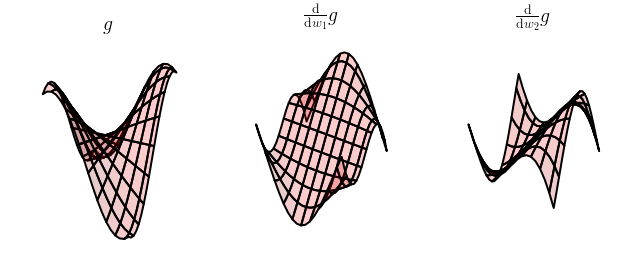

In [23]:
# define a function using our AD components
g = lambda w1,w2: sin(2*w1*w2)

# use custom plotter to evaluate function/derivative over a large range of inputs
calclib.derivative_3d_plotter.ad_3d_derval_plot(MyTuple,g)

## 2.5.5  Automatic Differentiation of higher order derivative values

The Automatic Differentiation (AD) calculator we built in the previous Section must be slightly adjusted if we are to use it to compute higher order derivatives.  First off, we need to adjust the base of our AD calculator - the variable $w$ - because now we need to keep track of more than just two values.  More specifically - as outlined in the hand calculations performed in the previous Subsection - if we are to compute the derivative of order $R$ we need to keep track of both the function and derivative value of every order up and equal to $R$.  We will do this by beginning with the same ``MyTuple`` object for representing $w$ - which holds its value and value of its derivative - and then we will recurse on this definition to create all of the necessary place-holders for higher order function / derivative values.

In [4]:
class MyTuple:
    '''
    The basic object representing the input variable 'w'
    represents the core of our AD calculator.  An instance 
    of this class is a tuple containining one function/derivative
    evaluation of the variable 'w'.  Because it is meant to 
    represent the simple variable 'w' the derivative 'der' is
    preset to 1.  The value 'val' can be set to 0 by default.  
    '''
    def __init__(self,**kwargs):
        # variables for the value (val) and derivative (der) of our input function 
        self.val = 0
        self.der = 1    
        
        # re-assign these default values 
        if 'val' in kwargs:
            self.val = kwargs['val']
        if 'der' in kwargs:
            self.der = kwargs['der']   

Below we create a full $R$ length tuple for our base function $w$.  This is a binary tree with $R$ levels, and two values per level.  At the $r^{th}$ level it contains function value and derivative of the $r^{th}$ order derivative.  In other words, when computing the derivative of order $R$ for some input function the object returned by ``` choose_order``` is essentially an array of length $R+1$ with a binary tree-based structure that contains all of the required values.

In [5]:
# make element capable or desired order calculations, will contain the function value as well as every derivative value up to and equal n         
def choose_order(order,**kwargs):
    # initialize first 
    w = MyTuple()
    if 'val' in kwargs:
        w = MyTuple(val = kwargs['val'])
        
    # recurse to create higher order derivative object
    for r in range(order-1):
        w = MyTuple(val = w)
    return(w)   

Next, to build effective recursion for each derivative rule we define the operation rules prior to those for each elementary function. Why?  Because they need not be changed: as defined for the first order calculator the operational rules are naturally recursive.  We repeat these here, adding a few more like negation and subtraction.

In [6]:
# our implementation of the addition rules from Table 2
def multiply(a,b):
    # Create output evaluation and derivative object
    c = MyTuple()

    # switch to determine if a or b is a constant
    if type(a) != MyTuple:
        c.val = a*b.val
        c.der = a*b.der
    elif type(b) != MyTuple:
        c.val = a.val*b
        c.der = a.der*b
    else: # both inputs are MyTuple objects
        c.val = a.val*b.val
        c.der = a.der*b.val + a.val*b.der     # product rule
    
    # Return updated object
    return c

In [7]:
# our implementation of the addition rules from Table 2
def add(a,b):
    # Create output evaluation and derivative object
    c = MyTuple()
    
    # switch to determine if a or b is a constant
    if type(a) != MyTuple:
        c.val = a + b.val
        c.der = b.der
    elif type(b) != MyTuple:
        c.val = a.val + b
        c.der = a.der
    else: # both inputs are MyTuple objects
        c.val = a.val + b.val
        c.der = a.der + b.der
    
    # Return updated object
    return c

In [8]:
# our implementation of the addition rules from Table 2
def subtract(a,b):
    # Create output evaluation and derivative object
    c = MyTuple()
    
    # switch to determine if a or b is a constant
    if type(a) != MyTuple:
        c.val = a - b.val
        c.der = b.der
    elif type(b) != MyTuple:
        c.val = a.val - b
        c.der = a.der
    else: # both inputs are MyTuple objects
        c.val = a.val - b.val
        c.der = a.der - b.der
    
    # Return updated object
    return c

In [9]:
# define negation
def negate(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    b.val = -a.val
    b.der = -a.der
    return b

We then overload these operators in the next cell.

In [10]:
# this next line overloads the addition operator for our MyTuple objects, or in other words adds the 'add' function to our MyTuple class definition on the fly
MyTuple.__add__ = add

# overload the reverse direction so that a + b = b + a
MyTuple.__radd__ = add

# this next line overloads the subtraction operator for our MyTuple objects, or in other words adds the 'add' function to our MyTuple class definition on the fly
MyTuple.__sub__ = subtract

# overload the reverse direction so that a + b = b + a
MyTuple.__rsub__ = subtract

# create two MyTuple objects and try to use Python's built in function assigned to the * operator on them
MyTuple.__mul__ = multiply

# overload the 'reverse multiplication' so that a*b = b*a
MyTuple.__rmul__ = multiply    

# create two MyTuple objects and try to use Python's built in function assigned to the ** operator on them
MyTuple.__neg__ = negate

While the derivative operation rules as employed with the first derivative AD calculator were naturally recursive, not all of those defined previously for the elementary functions were.  Therefore next we describe the small adjustment that needs to be made to each to make them so.

#### <span style="color:#a50e3e;">Example 5. </span> The power rule

Because we have already defined how multiplication treats MyTuple objects, the power rule as defined previously

In [11]:
# our implementation of the power rule from Table 1 
def power(a,n):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # Produce new function value - once '**' is overloaded this line will be recursive for MyTuple objects
    b.val = a.val**n

    # Produce new derivative value - once '**' is overloaded this line will be recursive for MyTuple objects
    b.der = n*(a.val**(n-1))*a.der
    
    # Return updated object
    return b

can be used immediately to compute higher order derivatives once we overload the ```**``` operator to make both the function and derivative updates recursive on MyTuple objects

In [12]:
# create two MyTuple objects and try to use Python's built in function assigned to the ** operator on them
MyTuple.__pow__ = power

Now we can compute e.g., the third derivative of $g(w) = w^4$ as in the next Python cell.

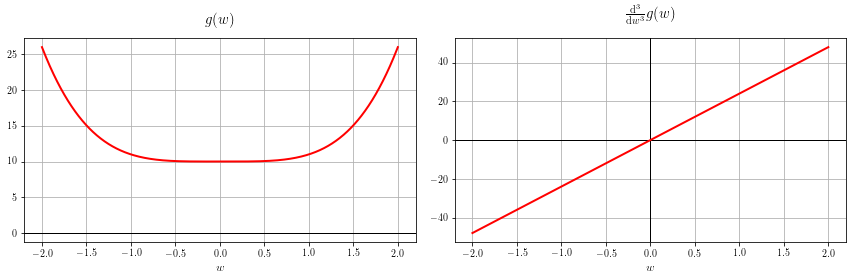

In [13]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: w**4 + 10
w = np.linspace(-2,2,1000)

# use the custom plotting function above to plot over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g,w=w,order=3)

#### <span style="color:#a50e3e;">Example 6. </span> Recursive derivative rule for $g(w) = \text{tanh}(w)$

We can easily adjust the tanh derivative rule to define higher order derivatives recursively.  We simply add a branch that re-evaluates the tanh function when the input is not a scalar value.

In [14]:
# our implementation of the power rule from Table 1 
def tanh(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # check if .val is constant, then last derivative to evaluate
    if type(a.val) != MyTuple:        
        # Calculate new current value
        b.val = np.tanh(a.val)

        # Calculate new current derivative value
        b.der = (1 - np.tanh(a.val)**2)*a.der
    else:    # the recursive branch
        # Calculate new current value
        b.val = tanh(a.val)

        # Calculate new current derivative value
        b.der = (1 - tanh(a.val)**2)*a.der
    
    # Return updated object
    return b

With our tanh function defined we can employ it to calculate general order derivatives of a wide range of functions.  For example, lets compute the fourth order derivative of

$$
g(w) = \text{tanh}(w^2)
$$

We do this in the next Python cell.

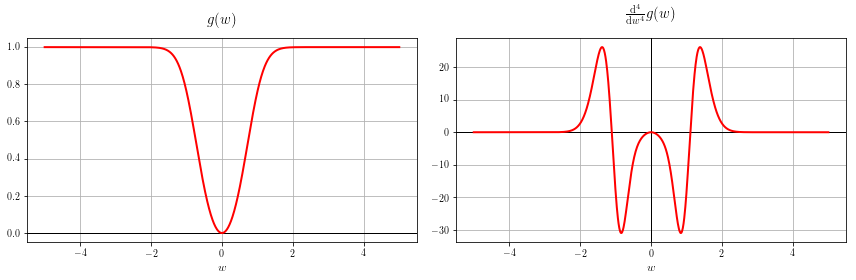

In [15]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: tanh(w**2)
w = np.linspace(-5,5,1000)

# use the custom plotting function above to plot over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g,w=w,order=4)

#### <span style="color:#a50e3e;">Example 7. </span> Recursive derivative rule for $g(w) = \text{sin}(w)$

To extend the sinusoid derivative rule we add a switch to the original function we made for the first order calculator.  This routes the derivative recursively when the input to the derivative function is itself a MyTuple object.

In [16]:
# our homemade sine function - made general to accept a function as input (hence the explicit application of the chain rule)
def sin(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # check if .val is constant, then last derivative to evaluate
    if type(a.val) != MyTuple:        
        # Calculate new current value
        b.val = np.sin(a.val)

        # Calculate new current derivative value
        b.der = np.cos(a.val)*a.der
    else:  # the new recursive branch
        # Calculate new current value
        b.val = sin(a.val)

        # Calculate new current derivative value
        b.der = cos(a.val)*a.der

    # Return updated object
    return b

Because the recursive branch here calls for us to push a MyTuple object through cosine, we need to construct this as well.  It essentially mirrors the sine function above, with a recursive branch to deal with MyTuple objects.

In [17]:
# our homemade sine function - made general to accept a function as input (hence the explicit application of the chain rule)
def cos(a):
    # Create output evaluation and derivative object
    b = MyTuple()
    
    # check if .val is constant, then last derivative to evaluate
    if type(a.val) != MyTuple:        
        # Calculate new current value
        b.val = np.cos(a.val)

        # Calculate new current derivative value
        b.der = -np.sin(a.val)*a.der
    else:
        # Calculate new current value
        b.val = cos(a.val)

        # Calculate new current derivative value
        b.der = -sin(a.val)*a.der

    # Return updated object
    return b

We can then put this to work on a simple test case 

$$
g(w) = \text{cos}(w) + 10
$$

and lets compute its fourth derivative.  Using the rules

$$
\frac{\mathrm{d}^4}{\mathrm{d}w^4}g(w) = \text{cos}(w)
$$

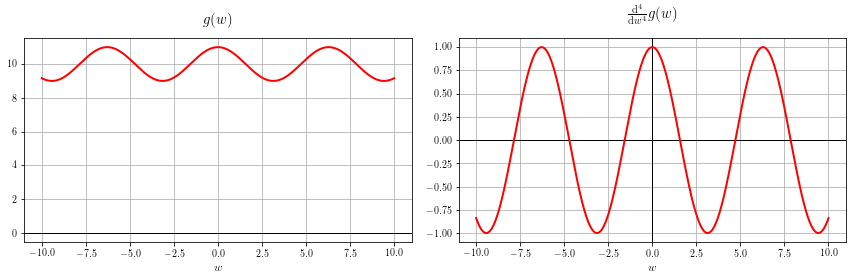

In [18]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: cos(w) + 10
w = np.linspace(-10,10,1000)

# use the custom plotting function above to plot over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g,w=w,order=4)

Another example, how about 

$$
g(w) = \text{sin}(w^3)
$$

and we take the $3^{rd}$ derivative of this.

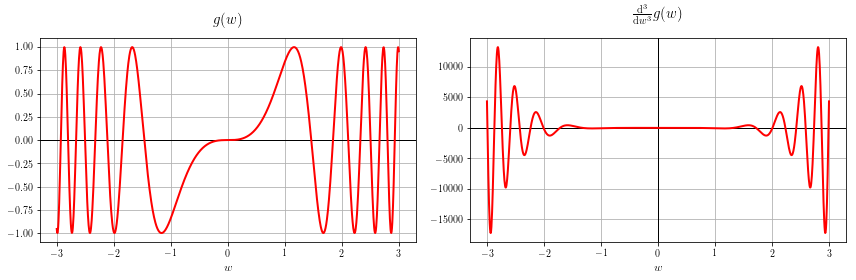

In [19]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: sin(w**3)
w = np.linspace(-3,3,1000)

# use the custom plotting function above to plot over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g,w=w,order=3)

Another example, how about 

$$
g(w) = \text{sin}(w^2)\text{tanh}^2(w)\text{cos}(10w) + w
$$

and we take the $2^{nd}$ derivative of this.

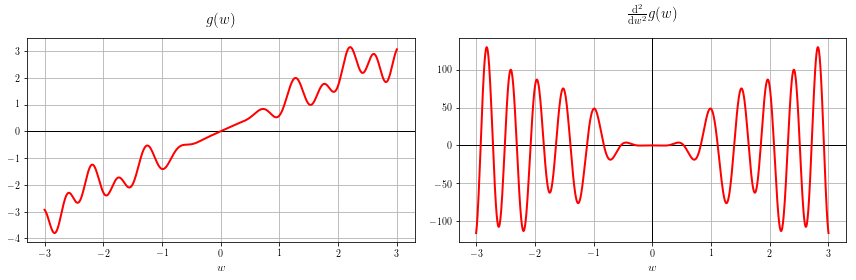

In [20]:
# create instance of our function to differentiate - notice this uses our homemade sine function not numpy's
g = lambda w: sin(w**2)*tanh(w)**2*cos(10*w) + w
w = np.linspace(-3,3,1000)

# use the custom plotting function above to plot over a large range of inputs
calclib.plotter.ad_derval_plot(MyTuple,g,w=w,order=2)

# Tree

Great little tree maker in Python


```http://anytree.readthedocs.io/en/latest/api/anytree.node.html```


there are of course ways to do this just with a composition of dictionaries like those listed here

https://stackoverflow.com/questions/2358045/how-can-i-implement-a-tree-in-python-are-there-any-built-in-data-structures-in

In [1]:
from anytree import AnyNode, RenderTree
root = AnyNode(id="root")
s0 = AnyNode(id="sub0", parent=root)
s0b = AnyNode(id="sub0B", parent=s0, foo=4, bar=109)
s0a = AnyNode(id="sub0A", parent=s0)
s1 = AnyNode(id="sub1", parent=root)
s1a = AnyNode(id="sub1A", parent=s1)
s1b = AnyNode(id="sub1B", parent=s1, bar=8)
s1c = AnyNode(id="sub1C", parent=s1)
s1ca = AnyNode(id="sub1Ca", parent=s1c)

In [2]:
root

AnyNode(id='root')

In [3]:
print(RenderTree(root))

AnyNode(id='root')
├── AnyNode(id='sub0')
│   ├── AnyNode(bar=109, foo=4, id='sub0B')
│   └── AnyNode(id='sub0A')
└── AnyNode(id='sub1')
    ├── AnyNode(id='sub1A')
    ├── AnyNode(bar=8, id='sub1B')
    └── AnyNode(id='sub1C')
        └── AnyNode(id='sub1Ca')


&copy; This material is not to be distributed, copied, or reused without written permission from the authors.